In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mdtraj as md
from scipy.optimize import curve_fit, least_squares
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import os, sys
from scipy.stats import binned_statistic
from scipy.stats import pearsonr, spearmanr
import seaborn as sns

se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'

# Download blocking code
!git clone https://github.com/fpesceKU/BLOCKING.git
sys.path.append('BLOCKING')
from main import BlockAnalysis

def error_prop_ratio(v1,v2,e1,e2):
    ratio = v1/v2
    return ratio*np.sqrt((e1/v1)**2+(e2/v2)**2)  

def calcProfiles(name,protein,temp=293,L=25,nskip=200):
    """Function to calculate csat and ccon from concentration profiles"""
    df_proteins = pd.read_csv('direct_coexistence/proteins.csv',index_col=0)
    filename = f'direct_coexistence/conc_profiles/{name:s}_{temp:d}.npy'
    if os.path.isfile(filename):
        h = np.load(filename)
        fasta = df_proteins.loc[protein].fasta
        N = len(fasta)
        conv = 100/6.022/N/L/L*1e3
        h = h[nskip:]*conv 
        lz = h.shape[1]+1
        edges = np.arange(-lz/2.,lz/2.,1)/10
        dz = (edges[1]-edges[0])/2.
        z = edges[:-1]+dz
        profile = lambda x,a,b,c,d : .5*(a+b)+.5*(b-a)*np.tanh((np.abs(x)-c)/d)
        residuals = lambda params,*args : ( args[1] - profile(args[0], *params) )
        hm = np.mean(h,axis=0)
        z1 = z[z>0]
        h1 = hm[z>0]
        z2 = z[z<0]
        h2 = hm[z<0]
        p0=[1,1,1,1]
        res1 = least_squares(residuals, x0=p0, args=[z1, h1], bounds=([0]*4,[100]*4))
        res2 = least_squares(residuals, x0=p0, args=[z2, h2], bounds=([0]*4,[100]*4))
        
        cutoffs1 = [res1.x[2]-.5*res1.x[3],-res2.x[2]+.5*res2.x[3]]
        cutoffs2 = [res1.x[2]+6*res1.x[3],-res2.x[2]-6*res2.x[3]]

        bool1 = np.logical_and(z<cutoffs1[0],z>cutoffs1[1])
        bool2 = np.logical_or(z>cutoffs2[0],z<cutoffs2[1])

        dilarray = np.apply_along_axis(lambda a: a[bool2].mean(), 1, h)
        denarray = np.apply_along_axis(lambda a: a[bool1].mean(), 1, h)

        dil = hm[bool2].mean()
        den = hm[bool1].mean()

        block_dil = BlockAnalysis(dilarray)
        block_den = BlockAnalysis(denarray)
        block_dil.SEM()
        block_den.SEM()
        return block_dil.av, block_dil.sem, block_den.av, block_den.sem
    else:
        print('DATA NOT FOUND FOR',name)
        
def plotMap(ax,mat,vmin,vmax,xlabel,ylabel,cmap=plt.cm.bwr,
            ori='vertical',
            cbar=True,cbarlabel='$U_E$ (pH 6) - $U_E$ (pH 8)  /  J mol$^{-1}$'):
    im = ax.imshow(mat,extent=[0, mat.shape[1],0, mat.shape[0]], 
                 cmap=cmap,
                 origin='lower',alpha=1,
                 vmin=vmin,vmax=vmax)
    """Function to plot contact maps"""
    if cbar:
        divider = make_axes_locatable(ax)
        if ori == 'vertical':
            cax = divider.new_horizontal(size="{:.1f}%".format(5), pad=.1)
        else:
            cax = divider.new_vertical(size="{:.1f}%".format(5), pad=.1)
        f.add_axes(cax)
        cb = f.colorbar(im, cax=cax, orientation=ori,
                    label=cbarlabel)
        cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
def calc_X_Y_mat(var,X_pos,Y_pos,temp=293):
    """Function to extract contacts between residue types from contact maps"""
    df = pd.DataFrame(0,index=X_pos,columns=Y_pos)
    mat = np.load(f'direct_coexistence/contact_maps/{var:s}_{temp:d}_s3.npy')
    for res1 in X_pos:
        for res2 in Y_pos:
            df.loc[res1,res2] = mat[res1,res2]
    return df

def calc_ave_mat(var,N,temp=293):
    """average over contact matrices calculated for segments of a simulation trajectory"""
    mat = np.zeros((N,N))
    for chunk in range(10):
        mat += np.load(f'direct_coexistence/contact_maps/{var:s}_{temp:d}_{chunk:d}_s3_mat.npy')
    np.save(f'direct_coexistence/contact_maps/{var:s}_{temp:d}_s3.npy',mat/10)
    
calc_ave_mat('CPEB4',448,temp=293)
calc_ave_mat('CPEB4pH6',448,temp=293)

Cloning into 'BLOCKING'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 286 (delta 25), reused 32 (delta 10), pack-reused 227
Receiving objects: 100% (286/286), 16.54 MiB | 3.10 MiB/s, done.
Resolving deltas: 100% (112/112), done.


In [2]:
df_proteins = pd.read_csv('direct_coexistence/proteins.csv',index_col=0)
df_proteins.fasta = df_proteins.fasta.apply(list)

In [3]:
!mkdir figures

### Time evolution of multimer sizes

8.6015625
8.578125


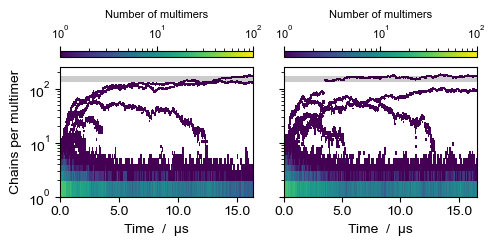

In [4]:
f, axes = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(5,2.5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

edges = np.arange(1,401,1)
x = edges[:-1]+(edges[1]-edges[0])/2.

for i in range(2):
    clust = pd.read_pickle(f'multimers/replica_{i:d}/clusters_CPEB4_60.pkl')
    rg = np.load(f'multimers/replica_{i:d}/CPEB4_400_293_60_rg.npy')
    print(rg.mean()*1.5)
    h = np.apply_along_axis(
        lambda a: np.histogram(a,bins=edges)[0]/x, 1, clust.size_chain_B)
    h = np.concatenate(
        [np.mean(h[i:i+10],axis=0,keepdims=True) for i in range(0,h.shape[0]//10*10,10)])
    im = axes[i].pcolor(h.T,norm=LogNorm(vmin=1,vmax=100))
    axes[i].set_ylim(1,250)
    divider = make_axes_locatable(axes[i])
    cax = divider.new_vertical(size="5%", pad=.1)
    f.add_axes(cax)
    cb = f.colorbar(im, cax=cax, orientation="horizontal",label='Number of multimers')
    cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')
    axes[i].set_xticks(range(0,h.shape[0]//10*10,100),
                         labels=[i/20 for i in range(0,h.shape[0]//10*10,100)])

    axes[i].set_yscale('log')
    axes[i].axhspan(130, 170, alpha=0.2, color='k', lw=0)
 
axes[0].set_ylabel('Chains per multimer')
axes[0].set_xlabel('Time  /  µs')
axes[1].set_xlabel('Time  /  µs')
    
plt.tight_layout()
plt.savefig('figures/multimers.png',dpi=300)
plt.show()

### Fig 2 h,i

In [5]:
var = 'CPEB4'
H_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='H')[0]
R_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='R')[0]
K_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='K')[0]
E_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='E')[0]
D_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='D')[0]
F_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='F')[0]
Y_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='Y')[0]
W_pos = np.where(np.asarray(df_proteins.loc[var].fasta)=='W')[0]
N_pos = np.sort(np.concatenate([E_pos,D_pos]))
Aro_pos = np.sort(np.concatenate([F_pos,Y_pos,W_pos]))

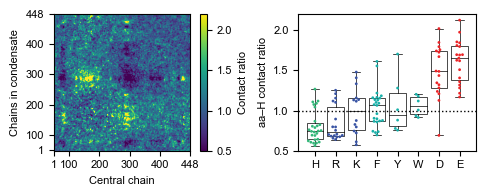

In [6]:
f, (ax1,ax2) = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(5,2))
plt.rcParams.update({ 'font.size': 8 })

ionic = 150
temp = 293
ene = 's3'

mat_pH8 = np.load(f'direct_coexistence/contact_maps/CPEB4_{temp:d}_s3.npy')

ratio = np.load(f'direct_coexistence/contact_maps/CPEB4pH6_{temp:d}_s3.npy') / mat_pH8

plotMap(ax1,ratio,.5,2.2,xlabel='Central chain',
    ylabel='Chains in condensate',cmap=plt.cm.viridis,
        ori='vertical',cbar=True,cbarlabel='Contact ratio')

ax1.set_yticks([1]+list(range(50,410,100))+[448],
                   ['{:d}'.format(int(i)) for i in [1]+list(range(100,410,100))+[448]])
ax1.set_xticks([1]+list(range(50,410,100))+[448],
                   ['{:d}'.format(int(i)) for i in [1]+list(range(100,410,100))+[448]])

####################################

ylorbr = mpl.cm.get_cmap('viridis')
colors = ylorbr(np.arange(0,.9,.1))
colors = ['#33B779','#3954A4','#3954A4','#19B0A9','#19B0A9','#19B0A9','#EC2427','#EC2427']

residues = np.empty(0)
energies = np.empty(0)
for res_pos,res in zip([H_pos,R_pos,K_pos,F_pos,Y_pos,W_pos,D_pos,E_pos],
                       ['H', 'R', 'K', 'F', 'Y', 'W', 'D', 'E']):
    ene_8 = calc_X_Y_mat('CPEB4',res_pos,H_pos) 
    ene_6 = calc_X_Y_mat('CPEB4pH6',res_pos,H_pos) 
    du = (ene_6/ene_8).mean(axis=1).values.flatten()
    energies = np.append(energies,du.tolist())
    residues = np.append(residues,[res]*du.size)
H_ene = pd.DataFrame({'residues':residues,'energies':energies})

boxprops = dict(linestyle='-', linewidth=.01, color='w')

sns.swarmplot(ax=ax2,data=H_ene,x='residues',y='energies',hue='residues',
              size=2,legend=False,palette=colors)
PROPS = {
    'boxprops':{'facecolor':'none', 'edgecolor':'k'},
    'medianprops':{'color':'k'},
    'whiskerprops':{'color':'k'},
    'capprops':{'color':'k'}
}
sns.boxplot(ax=ax2,data=H_ene,x='residues',y='energies',color='w', 
            whis=(0, 100),linewidth=.5,**PROPS)

ax2.set_ylabel('aa–H contact ratio')
ax2.set_xlabel('')
ax2.hlines(1,-.8,7.8,ls=':',color='k',lw=1)
ax2.set_xlim(-.8,7.8)
ax2.set_ylim(.5,2.2)
    
plt.tight_layout(w_pad=0)
plt.savefig('figures/fig2_hi.pdf')    
plt.show()

### Extended Data Fig 2 g

27 36 (27, 2)
18 36 (18, 2)
36 36 (27, 2)
18 36 (27, 2)


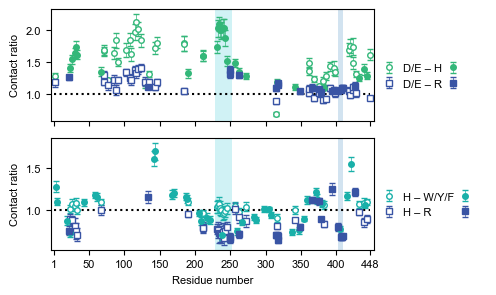

In [7]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(5,3))
plt.rcParams.update({ 'font.size': 8 })

colors = ['#33B779','#3954A4','#3954A4','#19B0A9','#19B0A9','#19B0A9','#EC2427','#EC2427']

for res_pos,label,c,m in zip([H_pos,R_pos],['D/E – H','D/E – R'],
                           ['#33B779','#3954A4'],['o','s']):
    
    ene_8 = calc_X_Y_mat('CPEB4',N_pos,res_pos) 
    ene_6 = calc_X_Y_mat('CPEB4pH6',N_pos,res_pos) 

    mean_std = (ene_6/ene_8).agg(['mean',se],axis=1)
    ax1.errorbar(x=N_pos,y=mean_std['mean'],color=c,lw=0,marker=m,mfc='w',
        yerr=mean_std['SE'],elinewidth=0.5,capsize=2,ms=4,label=label)

for res_pos,label,c,m in zip([H_pos,R_pos],['D/E – H','D/E – R'],
                           ['#33B779','#3954A4'],['o','s']):
    
    ene_8 = calc_X_Y_mat('CPEB4',res_pos,N_pos) 
    ene_6 = calc_X_Y_mat('CPEB4pH6',res_pos,N_pos) 
    
    mean_std = (ene_6/ene_8).agg(['mean',se],axis=1)
    print(res_pos.size,N_pos.size,mean_std.shape)
    ax1.errorbar(x=res_pos,y=mean_std['mean'],color=c,lw=0,marker=m,
        yerr=mean_std['SE'],elinewidth=0.5,capsize=2,ms=4,label=' ')
    
for res_pos,label,c,m in zip([Aro_pos,R_pos],['H – W/Y/F','H – R'],
                           ['#19B0A9','#3954A4'],['o','s']):
    
    ene_8 = calc_X_Y_mat('CPEB4',H_pos,res_pos) 
    ene_6 = calc_X_Y_mat('CPEB4pH6',H_pos,res_pos) 

    mean_std = (ene_6/ene_8).agg(['mean',se],axis=1)
    print(res_pos.size,N_pos.size,mean_std.shape)
    ax2.errorbar(x=H_pos,y=mean_std['mean'],color=c,lw=0,marker=m,mfc='w',
        yerr=mean_std['SE'],elinewidth=0.5,capsize=2,label=label,ms=4)
    
for res_pos,label,c,m in zip([Aro_pos,R_pos],['H – W/Y/F','H – R'],
                           ['#19B0A9','#3954A4'],['o','s']):
    
    ene_8 = calc_X_Y_mat('CPEB4',res_pos,H_pos) 
    ene_6 = calc_X_Y_mat('CPEB4pH6',res_pos,H_pos) 

    mean_std = (ene_6/ene_8).agg(['mean',se],axis=1)
    ax2.errorbar(x=res_pos,y=mean_std['mean'],color=c,lw=0,marker=m,
        yerr=mean_std['SE'],elinewidth=0.5,capsize=2,ms=4,label=' ')

ax1.hlines(1,1,448,ls=':',color='k')

ax2.hlines(1,1,448,ls=':',color='k')

for ax in [ax1,ax2]:
    ax.axvspan(229, 252, alpha=0.2, color='tab:cyan', lw=0)
    ax.axvspan(403, 410, alpha=0.2, color='tab:blue', lw=0)

ax2.set_xlim(1-5,448+5)
ax2.set_xticks([1]+list(range(50,410,50))+[448])

ax1.set_ylabel(r'Contact ratio')
ax2.set_ylabel(r'Contact ratio')

ax1.legend(loc=(1,.25),handletextpad=.2,frameon=False,ncol=2,columnspacing=0)
ax2.legend(loc=(1,.25),handletextpad=.2,frameon=False,ncol=2,columnspacing=0)

ax2.set_xlabel('Residue number')
plt.tight_layout()
plt.savefig('figures/fig2_ext_g.pdf')    
plt.show()

### Fig 3 i

149.68081063964536 17.466856126361186 0.05318331991786337


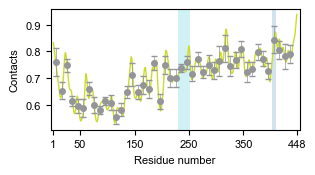

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(3.2,1.8))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 8})

profile = np.zeros(448)
n_frames_tot = 0
rgs = np.empty(0)
kappas = np.empty(0)
sizes = np.empty(0)

for i,s in enumerate(range(135,170,10)):
    for replica in range(2):
        filename = f'multimers/replica_{replica:d}/CPEB4_s3_293_60_{s:d}.npy'
        if os.path.isfile(filename):
            size,rg,kappa = np.loadtxt(
                f'multimers/replica_{replica:d}/CPEB4_size_rg_kappa_293_60_{s:d}.dat',unpack=True)
            sizes = np.append(sizes,size)
            rgs = np.append(rgs,rg)
            kappas = np.append(kappas,kappa)
            n_frames = sizes.size
            profile += np.load(filename).sum(axis=1)*n_frames
            n_frames_tot += n_frames
profile /= n_frames_tot

res_num = np.arange(1,profile.size+1,1)
    
y = gaussian_filter1d(profile, 2)
bins = res_num[::10]
ax1.plot(res_num,y,color='#CCDC2C',label='Droplet',lw=1)

wa_ene = binned_statistic(res_num,profile,bins=bins)[0]
wa_ene_err = binned_statistic(res_num,profile,bins=bins,statistic=se)[0]

ax1.errorbar(x=bins[:-1]+5,y=wa_ene,lw=0,marker='o',ms=4,
    yerr=wa_ene_err,elinewidth=0.5,capsize=2,color='#939598')

print(np.mean(sizes),np.mean(rgs),np.mean(kappas))

plt.xlim(1-5,448+5)
plt.xticks([1]+list(range(50,410,100))+[448])

plt.axvspan(229, 252, alpha=0.2, color='tab:cyan', lw=0)
plt.axvspan(403, 410, alpha=0.2, color='tab:blue', lw=0)

#plt.legend()
plt.xlabel('Residue number')
plt.ylabel('Contacts')
plt.tight_layout()
plt.savefig('figures/fig3_i.pdf')
plt.show()

### Extended Data Fig 2 e,f

variants = ['WT','H25S_Clust','DHClust','H25S','D4','H50S_Clust','WT pH6','H50S','WT pH7','D4_DHClust']
variants = ['WT','H25S_Clust','H25S','H50S_Clust','WT pH6','H50S','WT pH7']

df_c2 = pd.DataFrame(index=variants)

names = ['CPEB4','CPEB4H25S_Clust','CPEB4H25S',
         'CPEB4H50S_Clust','CPEB4pH6','CPEB4H50S','CPEB4pH7']

temp = 293

for i,(name,variant) in enumerate(zip(names,variants)):
    filename = f'direct_coexistence/conc_profiles/{name:s}_{temp:d}.npy'
    if os.path.exists(filename):
        h = np.load(filename)[:]
        conv = 100/6.022/len(df_proteins.loc[name].fasta)/25/25*1e3
        h = h*conv
        csat, csat_e, ccon, ccon_e = calcProfiles(name,name,temp=293,L=25,nskip=200)

        df_c2.loc[variant,'csat_ave'] = csat*1e3
        df_c2.loc[variant,'csat_err'] = csat_e*1e3
        df_c2.loc[variant,'ccon_ave'] = ccon
        df_c2.loc[variant,'ccon_err'] = ccon_e
df_c2.to_csv('direct_coexistence/csat_simulations.csv')

In [9]:
variants = ['H50Y','H25Y','WT','H25S_Clust','DHClust','H25S','D4','H50S_Clust','D4_DHClust','H50S']

cs_100 = pd.read_csv('direct_coexistence/csat_exp_30uMprotein_100mMNaCl_40C.csv',
                   index_col=0,usecols=(1,2,3,4,5)).rename({'WT_DHClust':'DHClust'}).loc[variants]

df_c2 = pd.read_csv('direct_coexistence/csat_simulations.csv',index_col=0)

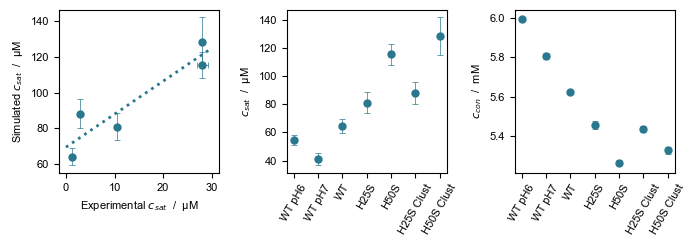

In [14]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(7,2.5))
plt.rcParams.update({ 'font.size': 8 })

ylorbr = mpl.cm.get_cmap('viridis')
colors = ylorbr(np.arange(0,1,.1))[::4]

variants = ['WT','H25S','H50S','H25S_Clust','H50S_Clust']
labels = [name.replace('_',' ') for name in variants]
ax1.errorbar(cs_100.loc[variants].csat_mean, df_c2.loc[variants].csat_ave,
         xerr=cs_100.loc[variants].csat_std,yerr=df_c2.loc[variants].csat_err, 
         marker='o', lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5,
         color=colors[1])
x = np.linspace(0, 30,1000)
popt,_ = curve_fit(lambda x,a,b : a*x+b,cs_100.loc[variants].csat_mean, df_c2.loc[variants].csat_ave)
ax1.plot(x,popt[0]*x+popt[1],ls=':',lw=2,zorder=4,color=colors[1])

ax1.set_ylabel('Simulated $c_{sat}$  /  µM')
ax1.set_xlabel('Experimental $c_{sat}$  /  µM')

variants = ['WT pH6','WT pH7','WT','H25S','H50S','H25S_Clust','H50S_Clust']
labels = [name.replace('_',' ') for name in variants]
ax2.errorbar(labels, df_c2.loc[variants].csat_ave,df_c2.loc[variants].csat_err, 
         marker='o', lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5,
         color=colors[1])

ax3.errorbar(labels, df_c2.loc[variants].ccon_ave,df_c2.loc[variants].ccon_err, 
         marker='o', lw=0, ms=5, elinewidth=.5, capsize=2, capthick=.5,
         color=colors[1])


ax2.set_ylabel('$c_{sat}$  /  µM')
ax3.set_ylabel('$c_{con}$  /  mM')
for ax in (ax2,ax3):
    for tick in ax.get_xticklabels():
        tick.set_rotation(60)

plt.tight_layout()
plt.savefig('figures/fig2_ext_ef.svg')    
plt.show()